In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Диагностика переобучения

### Диагностика моделей классификации

In [2]:
# Сгенерируем большой и сложный датасет с 500 атрибутами из которых 50 признаков будут информативны.

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=10000, n_features=500, 
                           n_informative=50, n_repeated=0, 
                           class_sep=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=3)

In [3]:
# Обучим на этом наборе логистическую регрессию

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)

print(f"Training accuracy score: {lr.score(X_train, y_train):.4f}")
print(f"Test accuracy: {lr.score(X_test, y_test):.4f}")

Training accuracy score: 0.8415
Test accuracy: 0.8056


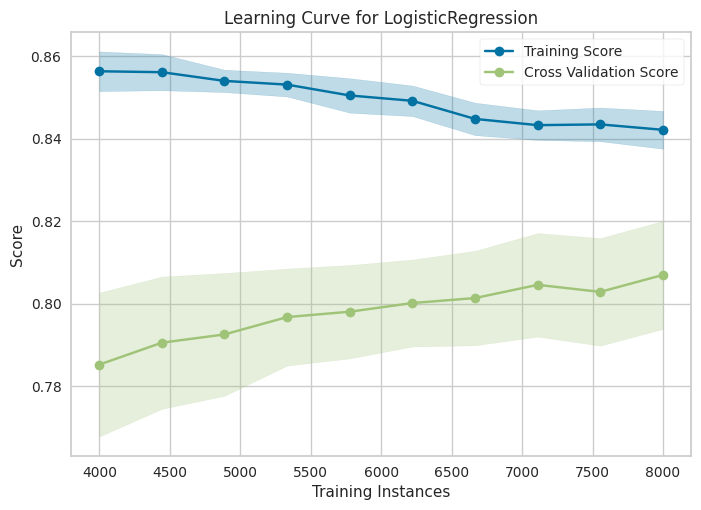

In [4]:
# Построим кривые обучения 
# LearningCurve построит модели логистической регрессии,
# обученные на 10%, 20%, и так далее до 100% обучающей выборкиу

from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    LogisticRegression(max_iter=1000), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

Эта кривая показывает, что когда модель учится на небольшом объеме данных, она имеет прекрасную обучающую эффективность, но плохую тестовую. По мере увеличения объема обучающей выборки, эти эффективности сближаются, но между ними все еще сохраняется зазор. Можно предположить, что модель немного переобучается. Более точно можно будет сказать сравнив эту модель с другими. Используем для этого гребневый классификатор с достаточно большим штрафом, накладываемым на коэффициенты модели. Это позволит сделать нашу модель проще.

In [5]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)

print(f"Training accuracy score: {lr.score(X_train, y_train):.4f}")
print(f"Test accuracy score: {lr.score(X_test, y_test):.4f}")

Training accuracy score: 0.7724
Test accuracy score: 0.7712


Эффективность стала заметно ниже. Плюс, значения почти совпадают. Это подтверждает первоначальный вывод о том, что в первой модели разница между обучающей и тестовой эффективностью получилась довольно большой для данной задачи. Построим кривые обучения для нашей второй модели.

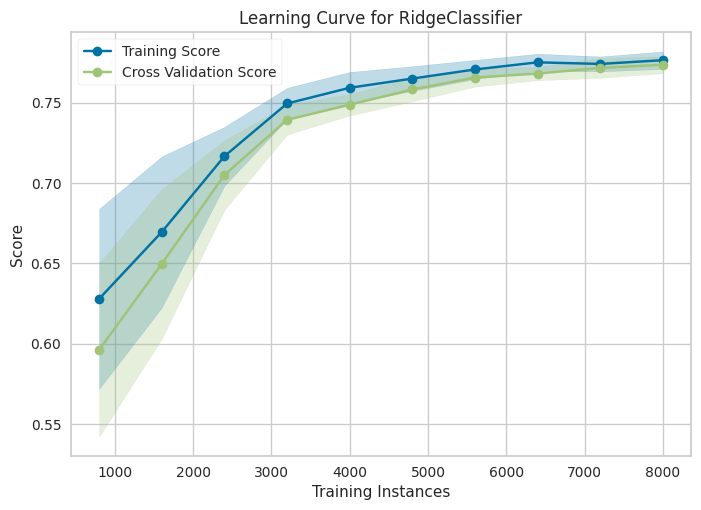

In [6]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y).show()

Данный график очень характерен для недообучения - низкие значения эффективности и практически никакой разницы между тестовой и обучающей эффективностью.

Построим график зависимости эффективности модели от значения параметра регуляризации. Для этого воспользуется логравномерным распределением.

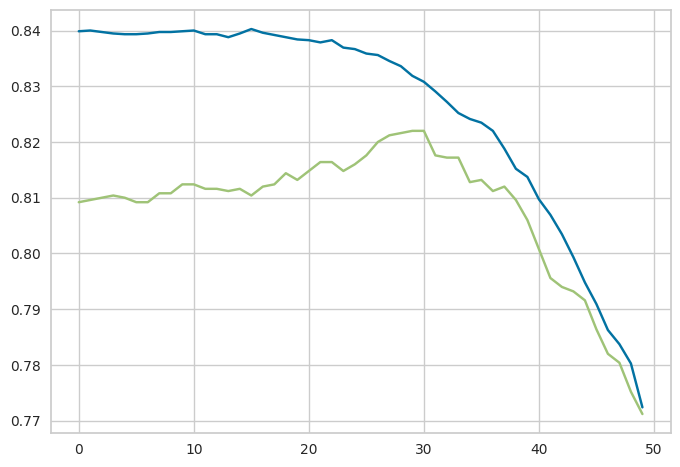

In [7]:
# построим 50 моделей с параметром регуляризации от 100 до 1_000_000

from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests)

In [8]:
tests.index(max(tests))

29

In [9]:
# Найдем значение параметра регуляризации 
np.logspace(2, 6, 50)[29]

23299.51810515372

In [10]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=23299.52).fit(X_train, y_train)

print(f"Training accuracy score: {lr.score(X_train, y_train):.4f}")
print(f"Test accuracy score: {lr.score(X_test, y_test):.4f}")

Training accuracy score: 0.8319
Test accuracy score: 0.8220


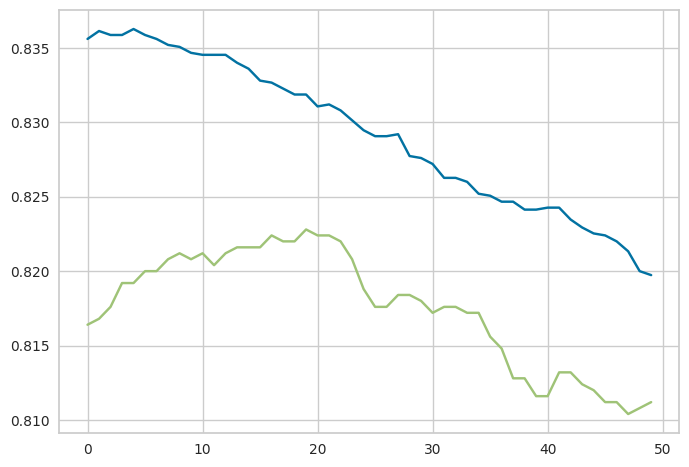

In [11]:
# Уменьшим масштаб 

from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(4, 5, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests)

In [12]:
tests.index(max(tests))

19

In [13]:
np.logspace(4, 5, 50)[19]

24420.5309454865

In [14]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=24420.53).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8319
Test score: 0.8228


Эта модель получилась немного лучше, чем самая первая. Это произошло потому, что мы за счет регуляризации убрали негативный эффект переобучения.

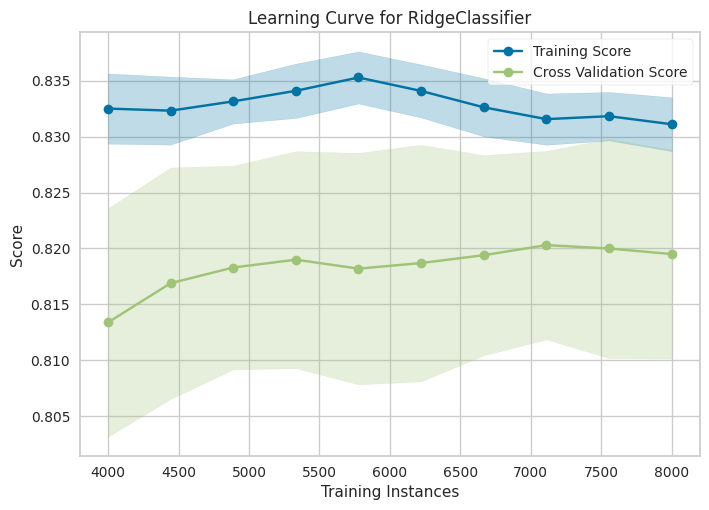

In [15]:
# Построим кривые обучения

visualizer = LearningCurve(
    RidgeClassifier(alpha=26500), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

Обращая внимание на масштаб вертикальной оси, видим, что и уровень эффективности выше, чем в первой модели и разница между двумя эффективностями тоже сократилась. И то и другое - это свидетельство большей обобщающей способности модели.

#### Precision

In [16]:
from sklearn.metrics import precision_score
lr = LogisticRegression().fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {precision_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {precision_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8339
Test precision: 0.8069


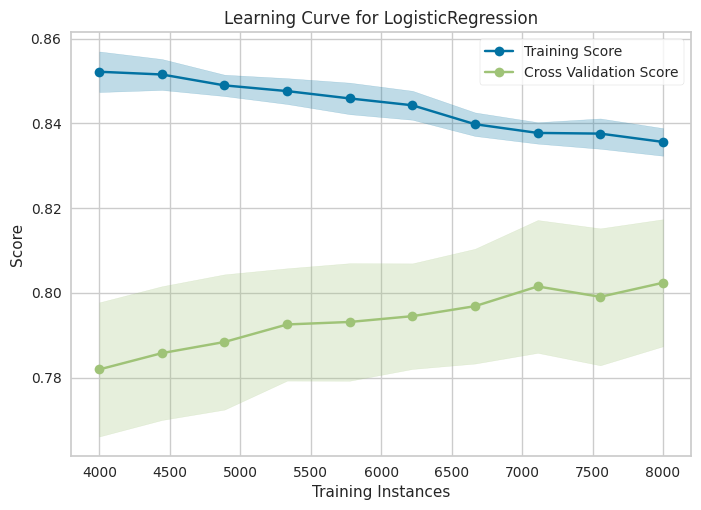

In [17]:
visualizer = LearningCurve(
    LogisticRegression(max_iter=1000), scoring="precision", train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

In [18]:
lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {precision_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {precision_score(y_test, y_pred_test):.4f}")

Training precision score: 0.7683
Test precision: 0.7678


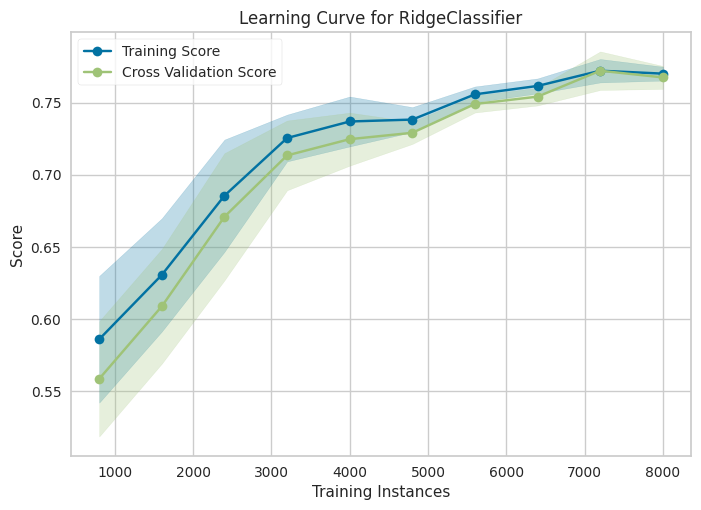

In [19]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), scoring="precision", train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y).show()

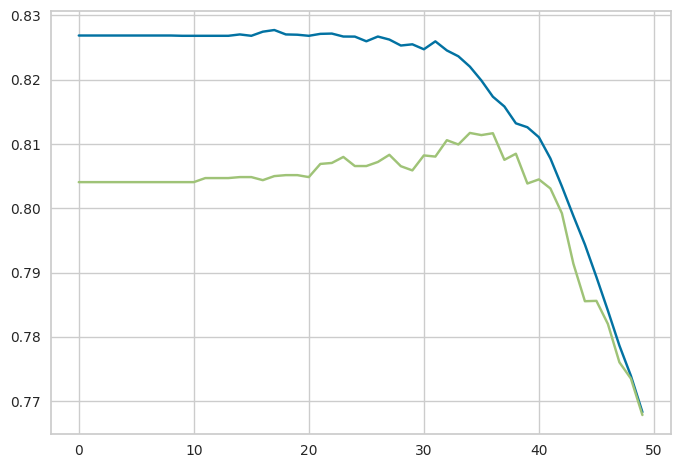

In [20]:
trains = []
tests = []
for i in np.logspace(0, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)
    trains.append(precision_score(y_train, y_pred_train))
    tests.append(precision_score(y_test, y_pred_test))

plt.plot(trains)
plt.plot(tests)

In [21]:
tests.index(max(tests))

34

In [22]:
np.logspace(0, 6, 50)[34]

14563.484775012445

In [23]:
lr = RidgeClassifier(alpha=np.logspace(0, 6, 50)[34]).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {precision_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {precision_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8220
Test precision: 0.8117


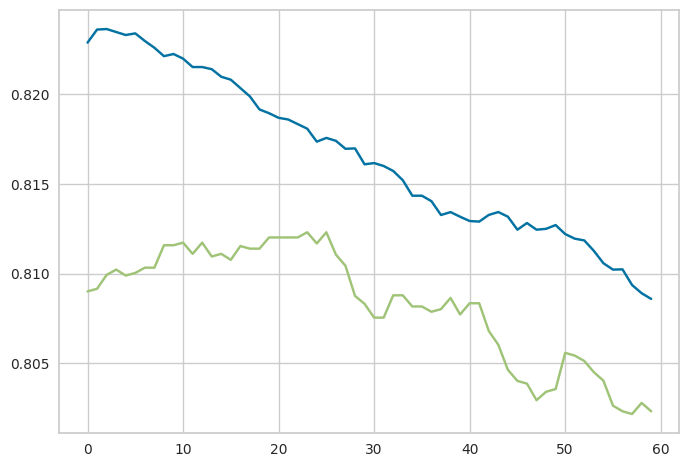

In [24]:
trains = []
tests = []
for i in np.logspace(4, 5, 60):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred_train2 = ridge.predict(X_train)
    y_pred_test2 = ridge.predict(X_test)
    trains.append(precision_score(y_train, y_pred_train2))
    tests.append(precision_score(y_test, y_pred_test2))

plt.plot(trains)
plt.plot(tests)

In [25]:
tests.index(max(tests))

23

In [26]:
np.logspace(4, 5, 60)[23]

24537.51106639817

In [27]:
lr = RidgeClassifier(alpha=24548).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {precision_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {precision_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8181
Test precision: 0.8123


#### Recall

In [28]:
from sklearn.metrics import recall_score
lr = LogisticRegression().fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {recall_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {recall_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8515
Test precision: 0.8056


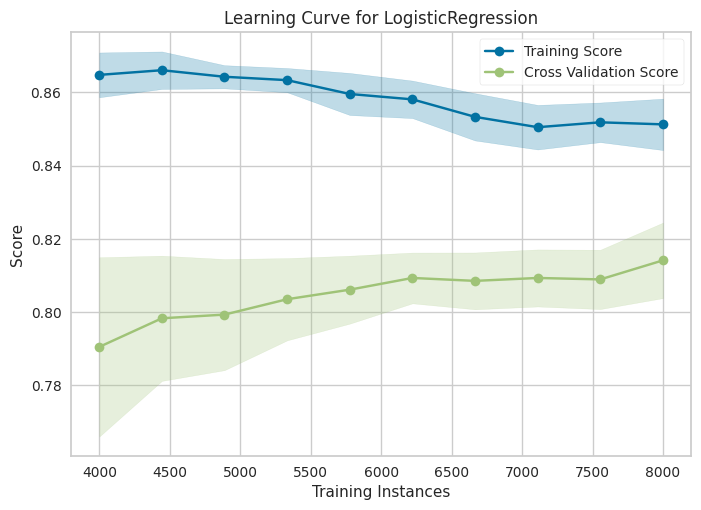

In [29]:
visualizer = LearningCurve(
    LogisticRegression(max_iter=1000), scoring="recall", train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

In [30]:
lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {recall_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {recall_score(y_test, y_pred_test):.4f}")

Training precision score: 0.7780
Test precision: 0.7801


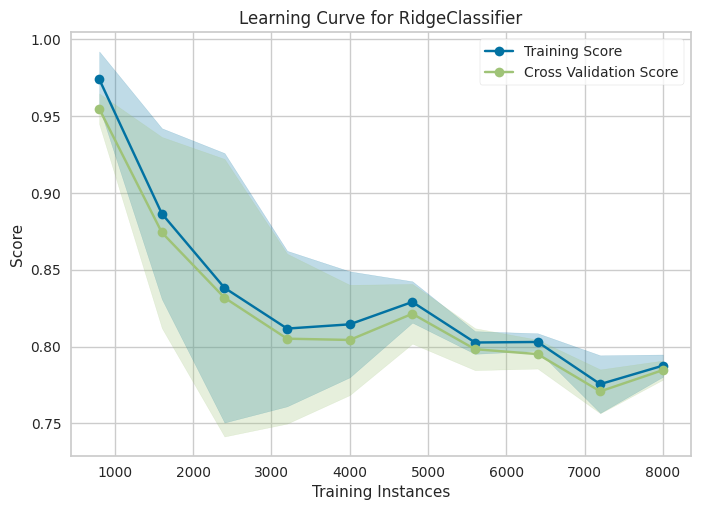

In [31]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), scoring="recall", train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y).show()

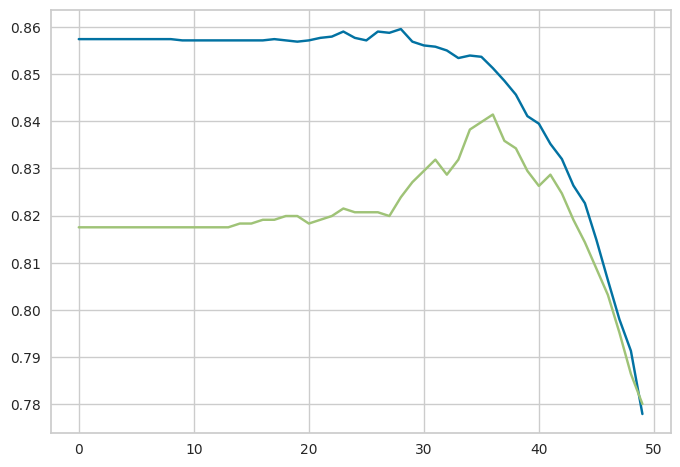

In [32]:
trains = []
tests = []
for i in np.logspace(0, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)
    trains.append(recall_score(y_train, y_pred_train))
    tests.append(recall_score(y_test, y_pred_test))

plt.plot(trains)
plt.plot(tests)

In [33]:
tests.index(max(tests))

36

In [34]:
np.logspace(0, 6, 50)[36]

25595.479226995332

In [35]:
lr = RidgeClassifier(alpha=np.logspace(0, 6, 50)[36]).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {recall_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {recall_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8513
Test precision: 0.8414


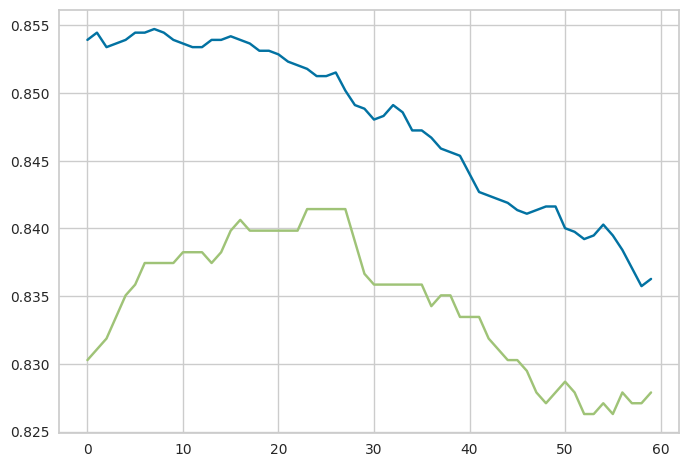

In [36]:
trains = []
tests = []
for i in np.logspace(4, 5, 60):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred_train2 = ridge.predict(X_train)
    y_pred_test2 = ridge.predict(X_test)
    trains.append(recall_score(y_train, y_pred_train2))
    tests.append(recall_score(y_test, y_pred_test2))

plt.plot(trains)
plt.plot(tests)

In [37]:
tests.index(max(tests))

23

In [38]:
np.logspace(4, 5, 60)[24]

25514.065200312874

In [39]:
lr = RidgeClassifier(alpha=26400).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {recall_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {recall_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8513
Test precision: 0.8414


#### F1-score

In [40]:
from sklearn.metrics import f1_score
lr = LogisticRegression().fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {f1_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {f1_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8426
Test precision: 0.8062


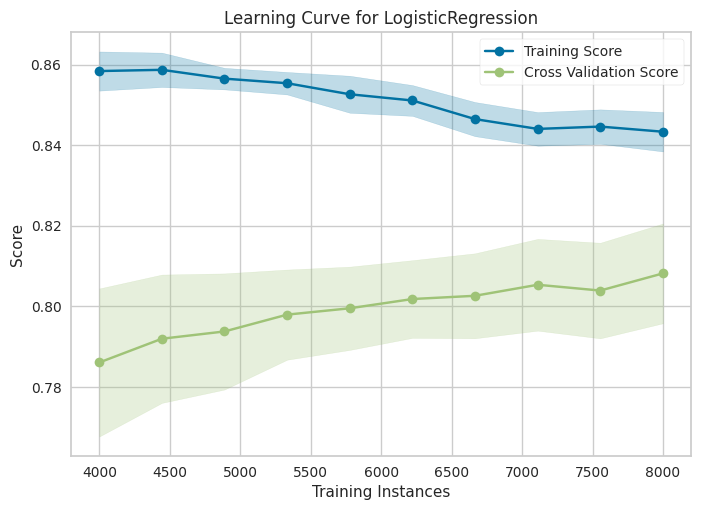

In [41]:
visualizer = LearningCurve(
    LogisticRegression(max_iter=1000), scoring="f1", train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

In [42]:
lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {f1_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {f1_score(y_test, y_pred_test):.4f}")

Training precision score: 0.7731
Test precision: 0.7739


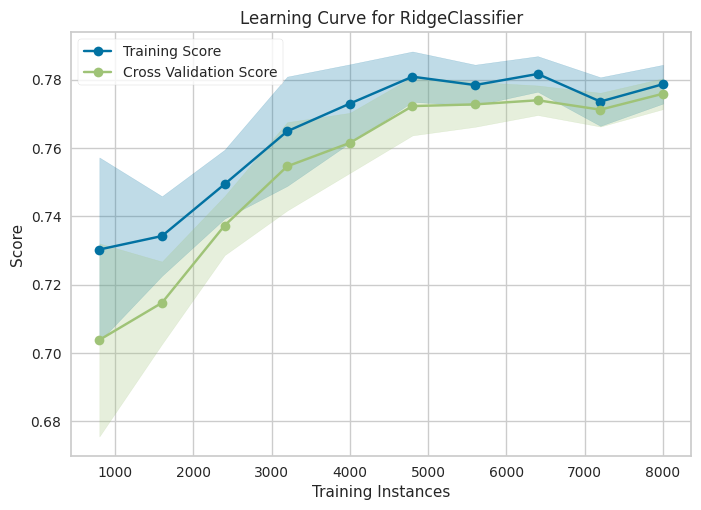

In [43]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), scoring="f1", train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y).show()

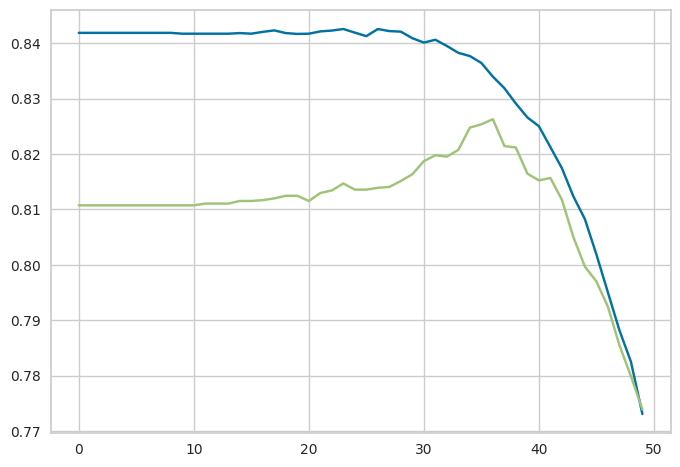

In [44]:
trains = []
tests = []
for i in np.logspace(0, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)
    trains.append(f1_score(y_train, y_pred_train))
    tests.append(f1_score(y_test, y_pred_test))

plt.plot(trains)
plt.plot(tests)

In [45]:
tests.index(max(tests))

36

In [46]:
np.logspace(0, 6, 50)[36]

25595.479226995332

In [47]:
lr = RidgeClassifier(alpha=np.logspace(0, 6, 50)[36]).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {f1_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {f1_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8340
Test precision: 0.8263


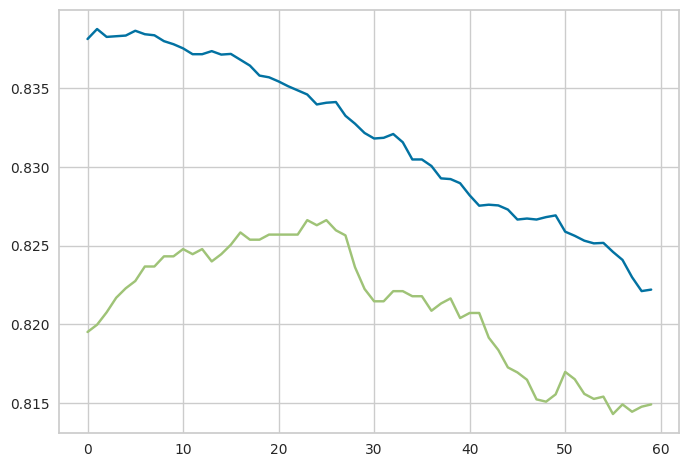

In [48]:
trains = []
tests = []
for i in np.logspace(4, 5, 60):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    y_pred_train2 = ridge.predict(X_train)
    y_pred_test2 = ridge.predict(X_test)
    trains.append(f1_score(y_train, y_pred_train2))
    tests.append(f1_score(y_test, y_pred_test2))

plt.plot(trains)
plt.plot(tests)

In [49]:
tests.index(max(tests))

23

In [50]:
np.logspace(4, 5, 60)[23]

24537.51106639817

In [51]:
lr = RidgeClassifier(alpha=24548).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f"Training precision score: {f1_score(y_train, y_pred_train):.4f}")
print(f"Test precision: {f1_score(y_test, y_pred_test):.4f}")

Training precision score: 0.8346
Test precision: 0.8266


Выводы: accuracy = 0.82; precision = 0.81; recall = 0.84; f1 = 0.83
При этом параметры регуляризации для каждой метрики отличаются незначительно. Значит борьба с переобучением и недообучением прошла успешно

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Диагностика моделей регрессии

Для более реалистичного примера загрузим датасет цен на недвижимость:

In [52]:
from numpy import genfromtxt
dataset = genfromtxt('https://raw.githubusercontent.com/m-mehdi/tutorials/main/boston_housing.csv', delimiter=',')
X = dataset[:,:-1]
y = dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [53]:
from sklearn.linear_model import LinearRegression, Ridge
lr = LinearRegression().fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.2f}")
print(f"Test score: {lr.score(X_test, y_test):.2f}")

Training score: 0.95
Test score: 0.61


Сразу можно сказать, что мы сталкнулись с переобучением

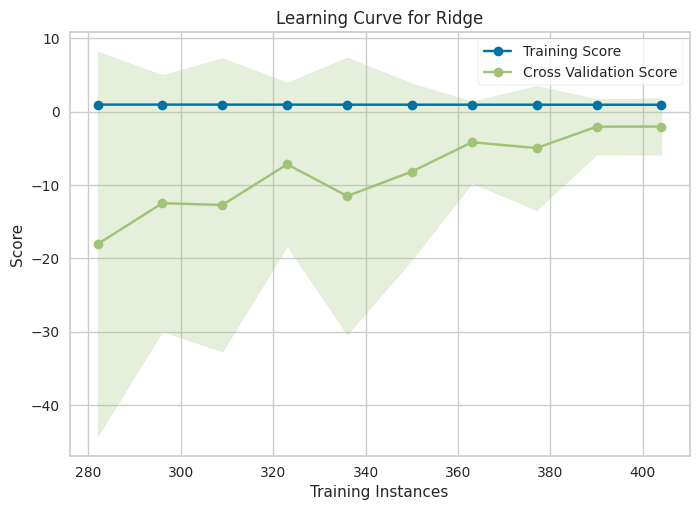

In [54]:
from yellowbrick.model_selection import LearningCurve

# Используем гребневую Регрессию с малым пораметром регуляризации
visualizer = LearningCurve(
    Ridge(alpha=0.0001), scoring='r2', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X, y).show() 

Так и есть: наша модель переобучилась.

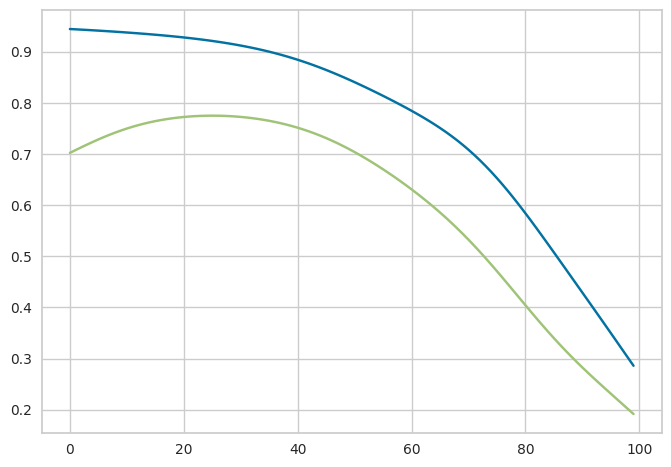

In [55]:
# Построим график зависимости эффективности модели
# от значения параметра регуляризации

trains = []
tests = []
for i in np.logspace(-2, 3, 100):
    ridge = Ridge(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))
plt.plot(trains)
plt.plot(tests)

Узнаем параметр регуляризации при котором модель имеет наилучшие характеристики

In [56]:
tests.index(max(tests))

25

In [57]:
np.logspace(-2, 3, 100)[25]

0.18307382802953678

In [58]:
lr = Ridge(alpha=0.18).fit(X_train, y_train)

print(f"Ridge Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"Ridge Regression-Test set score: {lr.score(X_test, y_test):.2f}")

Ridge Regression-Training set score: 0.92
Ridge Regression-Test set score: 0.77


Можно видеть, что новые значения r2 значительно выше, чем у первой модели

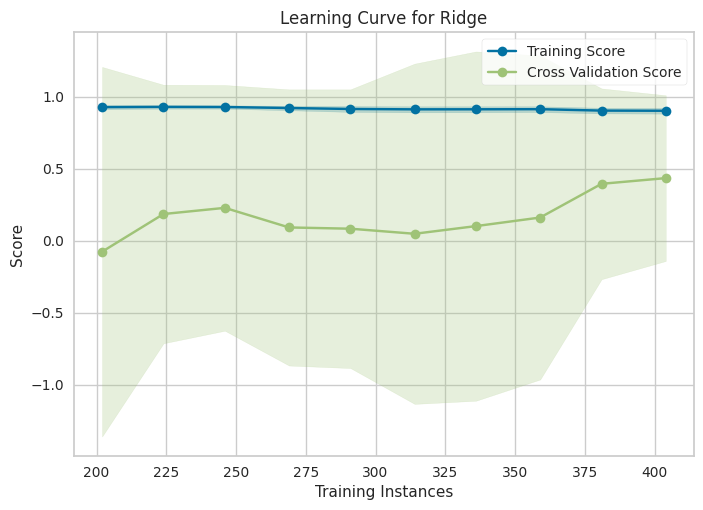

In [59]:
visualizer = LearningCurve(
    Ridge(alpha=0.18), scoring='r2', train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

По сравнению с предыдущим графиком этот выглядит гораздо адекватнее.
Однако стоит отметить, что результат все так же выглядят плачевно (видно недообучение), поэтому стоит исследовать этот датасет на более сложных моделях

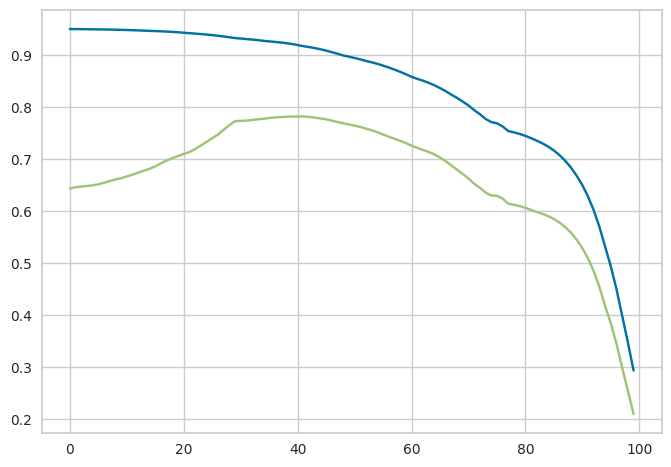

In [60]:
# Используем модель Лассо. Она использует l1-норму регуляризации

from sklearn.linear_model import Lasso
trains = []
tests = []
for i in np.logspace(-4, 0, 100):
    ridge = Lasso(alpha=i, max_iter=50000).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")

In [61]:
tests.index(max(tests))

41

In [62]:
np.logspace(-4, 0, 100)[41]

0.004534878508128582

In [63]:
lr = Lasso(alpha=0.00453, max_iter=50000).fit(X_train, y_train)

print(f"Lasso Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"Lasso Regression-Test set score: {lr.score(X_test, y_test):.2f}")

Lasso Regression-Training set score: 0.92
Lasso Regression-Test set score: 0.78


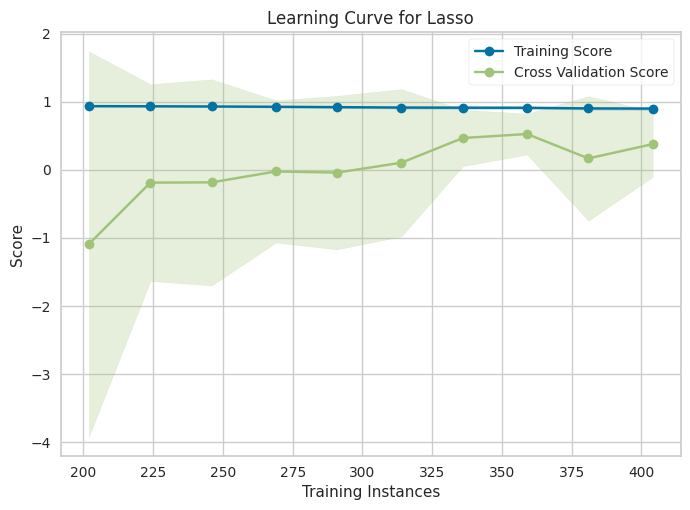

In [64]:
visualizer = LearningCurve(
    Lasso(alpha=0.00453, max_iter=50000).fit(X_train, y_train), scoring='r2', train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show() 

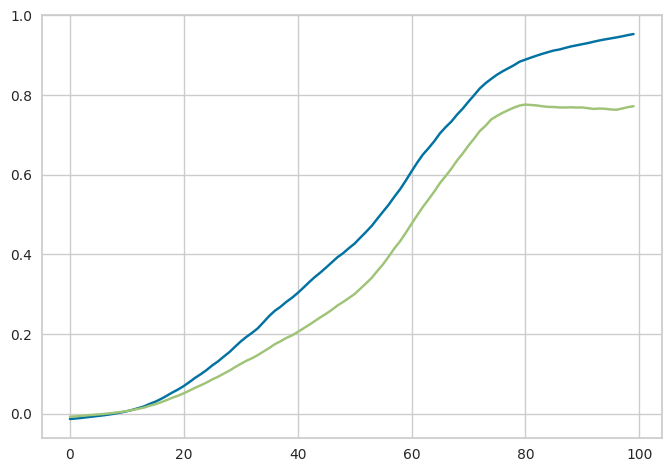

In [65]:
# Исследуем влияние параметра С (величина равная квадрату l2) в методе опорных векторов с полиномиальным ядром

from sklearn.svm import SVR

trains = []
tests = []
for i in np.logspace(-4, 2, 100):
    reg = SVR(kernel='poly', degree=3,  C=i, epsilon=0.2).fit(X_train, y_train)
    trains.append(reg.score(X_train, y_train))
    tests.append(reg.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")

In [66]:
tests.index(max(tests))

80

In [67]:
np.logspace(-4, 2, 100)[80]

7.054802310718645

In [68]:
lr = SVR(kernel='poly', degree=3,  C=7.055, epsilon=0.2).fit(X_train, y_train)

print(f"SVRegression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"SVRegression-Test set score: {lr.score(X_test, y_test):.2f}")

SVRegression-Training set score: 0.89
SVRegression-Test set score: 0.78


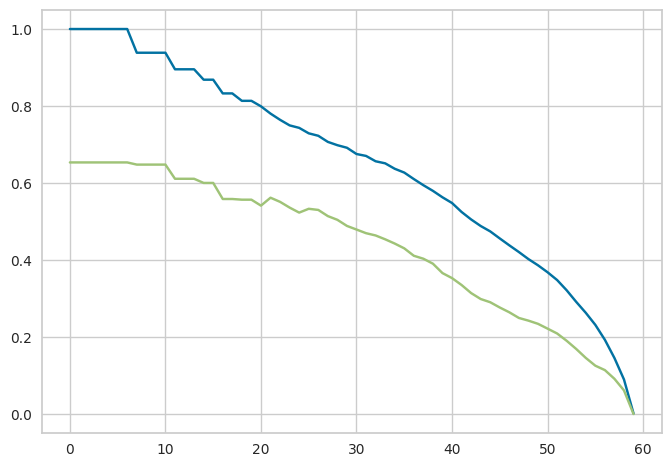

In [69]:
# Исследуем влияние количества соседей в модели ближайших соседей
from sklearn.neighbors import KNeighborsRegressor

trains = []
tests = []
for i in np.geomspace(1, 378, 60, dtype='int'):
    reg = KNeighborsRegressor(n_neighbors=i).fit(X_train, y_train)
    trains.append(reg.score(X_train, y_train))
    tests.append(reg.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")

На графике видно, что модель имеет очень сильное переобучение при маленоком количестве соседей и недообучение при большом.     
Вывод: модель не предназначена для кластеризации

In [70]:
np.geomspace(1, 378, 60, dtype='int')[10]

2

In [71]:
lr = KNeighborsRegressor(n_neighbors=2).fit(X_train, y_train)

print(f"KNeighborsRegression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"KNeighborsRegression-Test set score: {lr.score(X_test, y_test):.2f}")

KNeighborsRegression-Training set score: 0.94
KNeighborsRegression-Test set score: 0.65


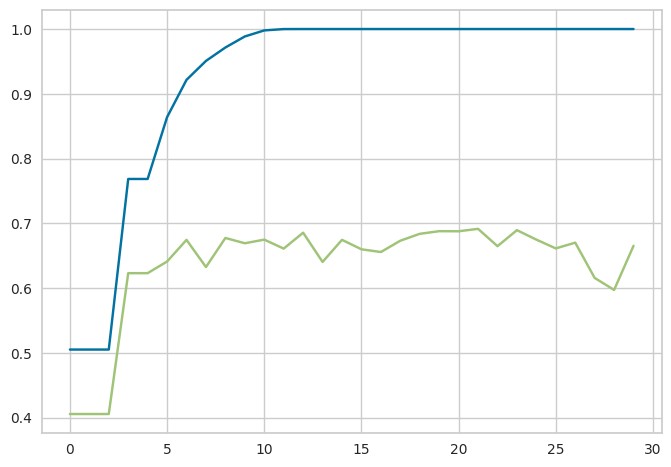

In [72]:
# Исследуем как максимальная глубина решающего дерева влияет на модель
from sklearn.tree import DecisionTreeRegressor

trains = []
tests = []
for i in np.geomspace(1, 1000, 30, dtype='int'):
    reg = DecisionTreeRegressor(max_depth=i).fit(X_train, y_train)
    trains.append(reg.score(X_train, y_train))
    tests.append(reg.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")

In [73]:
np.geomspace(1, 1000, 30, dtype='int')[15]

35

!!! Стоит отметить, что в разных задачах стоит брать разное значение (можно взять значение 3 и доучить модель или взять 15 для достижения максимального профита)

In [74]:
lr = DecisionTreeRegressor(max_depth=35).fit(X_train, y_train)

print(f"DecisionTreeRegression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"DecisionTreeRegression-Test set score: {lr.score(X_test, y_test):.2f}")

DecisionTreeRegression-Training set score: 1.00
DecisionTreeRegression-Test set score: 0.60


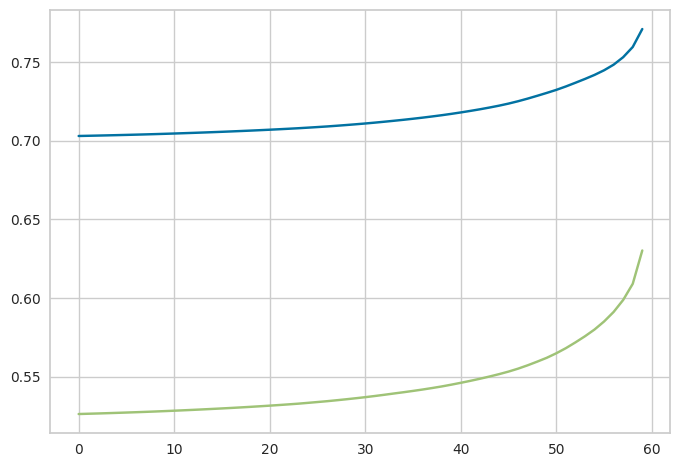

In [75]:
# Влияние параметра смешивания l1 и l2 (l1_ratio) ElasticNet:

from sklearn.linear_model import ElasticNet

trains = []
tests = []
for i in np.logspace(np.log10(1), np.log10(10), num=60, endpoint=True)/10:
    reg = ElasticNet(alpha=0.1, l1_ratio=i).fit(X_train, y_train)
    trains.append(reg.score(X_train, y_train))
    tests.append(reg.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")



In [76]:
 (np.logspace(np.log10(1), np.log10(10), num=60, endpoint=True)/10)[59]

1.0

In [77]:
lr = ElasticNet(alpha=0.1, l1_ratio=1).fit(X_train, y_train)

print(f"ElasticNet Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"ElasticNet Regression-Test set score: {lr.score(X_test, y_test):.2f}")

ElasticNet Regression-Training set score: 0.77
ElasticNet Regression-Test set score: 0.63


## --------------------------------------------------------------------------------------------------------------------------------------

## Диагностика недообучения

In [78]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='delta_ailerons')
data.data.shape

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(7129, 5)

In [79]:
X = pd.get_dummies(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.6058
Test score = 0.5940


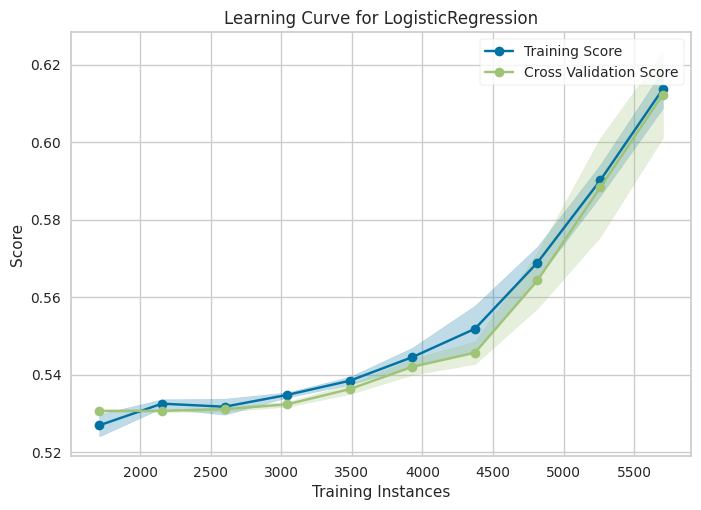

In [81]:
visualizer = LearningCurve(
    LogisticRegression(), scoring='accuracy', train_sizes=np.linspace(0.3, 1.0, 10)
).fit(X, y).show() 

Здесь очевидны признаки недообучения: низкий уровень обучающей эффективности, малый разрыв между обучающей и тестовой эффективностью. При недообучении регуляризация не поможет, даже навредит, так как еще усилит его. Поэтому единственный путь в этом случае - использовать более сложные, вариативные модели. Можно, например, попробовать многослойный перцептрон

In [82]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=300).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9386
Test score = 0.9397


Или полиномиальные модели

In [83]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures

model = RidgeClassifier(alpha=0.001).fit(PolynomialFeatures(2).fit_transform(X_train), y_train)
y_train_pred = model.predict(PolynomialFeatures(2).fit_transform(X_train))
y_pred = model.predict(PolynomialFeatures(2).fit_transform(X_test))
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9392
Test score = 0.9362


Для этой полиномиальной модели уже можно пробовать использовать регуляризацию и строить соответствующие кривые:

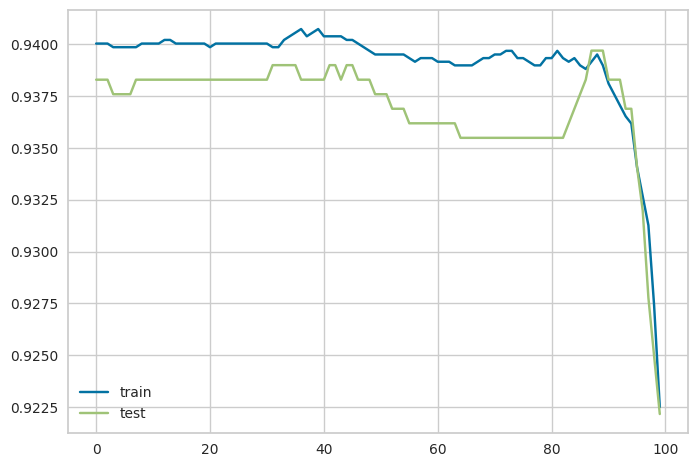

In [84]:
from sklearn.linear_model import RidgeClassifier

trains = []
tests = []
for i in np.logspace(-7, 0, 100):
    ridge = RidgeClassifier(alpha=i).fit(PolynomialFeatures(2).fit_transform(X_train), y_train)
    trains.append(ridge.score(PolynomialFeatures(2).fit_transform(X_train), y_train))
    tests.append(ridge.score(PolynomialFeatures(2).fit_transform(X_test), y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()